In [32]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from tqdm import tqdm
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve

import numpy as np
import polars as pl
from hydra import compose, initialize, core
from omegaconf import OmegaConf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nopep8
import tensorflow as tf

import matplotlib.pyplot as plt
import optuna

sys.path.append(os.path.dirname(os.getcwd()))
from src.custom_utils import get_secret, get_db_url, StudyVisualizer

## Hydrda

In [88]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='tf_keras_notebook')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

## S3

In [3]:
s3 = boto3.client('s3')

train_val_path = {'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
                  'val': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val'}
train_val_path

{'train': 's3://yang-ml-sagemaker/census-income-classification/input-data/train',
 'val': 's3://yang-ml-sagemaker/census-income-classification/input-data/val'}

## SageMaker

In [150]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
ecr_boto3 = boto3.client('ecr')
role = sagemaker.get_execution_role()

## Database

In [5]:
cf = boto3.client('cloudformation')
outputs = cf.describe_stacks(StackName=config['stack_name'])['Stacks'][0]['Outputs']

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'ClusterEndpoint'][0].split(':')[0]
db_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DatabaseName'][0]
secret_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DBSecretArn'][0].split(':')[-1].split('-')[0]

subnets = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'PrivateSubnets'][0].split(',')
security_group_ids = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'SageMakerSecurityGroup'][0].split(',')

## Tensorflow

Test locally:

In [6]:
test_study_name = 'test-study'

test_estimator = TensorFlow(
    entry_point=config['tf_keras']['entry_point'],
    source_dir=config['src_dir_path'],
    role=role,
    py_version=config['tf_keras']['py_version'],
    framework_version=config['tf_keras']['framework_version'],
    model_dir=config['model_dir'],
    output_path=config['output_path'],
    code_location=config['code_location'],
    instance_type='local',
    instance_count=config['tf_keras']['instance_count'],
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'study_name': test_study_name,
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'n_trials': 2,
        'test_mode': 1
    }
)

test_estimator

In [7]:
!sudo rm -rf /tmp/tmp*

In [8]:
test_estimator.fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-08-19-12-01-41-059
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-cbeqv:
    command: train
    container_name: bn0rsia7uw-algo-1-cbeqv
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.13.0-cpu-py310
    networks:
      sagemaker-local:
        aliases:
        - algo-1-cbeqv
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpyeuxas7w/algo-1-cbeqv/output:/opt/ml/output
  

Creating bn0rsia7uw-algo-1-cbeqv ... 
Creating bn0rsia7uw-algo-1-cbeqv ... done
Attaching to bn0rsia7uw-algo-1-cbeqv
bn0rsia7uw-algo-1-cbeqv | 2023-08-19 12:01:44.777151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
bn0rsia7uw-algo-1-cbeqv | To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
bn0rsia7uw-algo-1-cbeqv | 2023-08-19 12:01:48,537 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
bn0rsia7uw-algo-1-cbeqv | 2023-08-19 12:01:48,539 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
bn0rsia7uw-algo-1-cbeqv | 2023-08-19 12:01:48,540 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
bn0rsia7uw-algo-1-cbeqv | 2023-08-19 12:01:48,556 sagemaker-training-toolkit INFO     instance_groups e

INFO:root:creating /tmp/tmpyeuxas7w/artifacts/output/data
INFO:root:copying /tmp/tmpyeuxas7w/algo-1-cbeqv/output/success -> /tmp/tmpyeuxas7w/artifacts/output
INFO:root:creating /tmp/tmpyeuxas7w/artifacts/model/00000000
INFO:root:creating /tmp/tmpyeuxas7w/artifacts/model/00000000/variables
INFO:root:copying /tmp/tmpyeuxas7w/model/00000000/variables/variables.data-00000-of-00001 -> /tmp/tmpyeuxas7w/artifacts/model/00000000/variables


bn0rsia7uw-algo-1-cbeqv exited with code 0
Aborting on container exit...


INFO:root:copying /tmp/tmpyeuxas7w/model/00000000/variables/variables.index -> /tmp/tmpyeuxas7w/artifacts/model/00000000/variables
INFO:root:creating /tmp/tmpyeuxas7w/artifacts/model/00000000/assets
INFO:root:copying /tmp/tmpyeuxas7w/model/00000000/fingerprint.pb -> /tmp/tmpyeuxas7w/artifacts/model/00000000
INFO:root:copying /tmp/tmpyeuxas7w/model/00000000/saved_model.pb -> /tmp/tmpyeuxas7w/artifacts/model/00000000
INFO:root:copying /tmp/tmpyeuxas7w/model/00000000/keras_metadata.pb -> /tmp/tmpyeuxas7w/artifacts/model/00000000


===== Job Complete =====


In [7]:
db_url = get_db_url(host=host, db_name=db_name, db_secret=secret_name, region_name=sagemaker_session._region_name)

optuna.study.delete_study(study_name=test_study_name, storage=db_url)

Re-instantiate estimator:

In [103]:
tf_estimator = TensorFlow(
    # Entry point
    entry_point=config['tf_keras']['entry_point'],
    source_dir=config['src_dir_path'],
    py_version=config['tf_keras']['py_version'],
    framework_version=config['tf_keras']['framework_version'],
    # Sagemaker
    role=role,
    instance_type=config['tf_keras']['instance_type'],
    instance_count=config['tf_keras']['instance_count'],
    model_dir=config['model_dir'],
    output_path=config['output_path'],
    code_location=config['code_location'],
    volume_size=config['volume_size'],
    base_job_name=config['tf_keras']['base_job_name'],
    sagemaker_session=sagemaker_session,
    # Spot traning
    # max_run=config['max_run'],
    # max_wait=config['max_run'], # Equal or greater than max_run
    # max_retry_attempts=config['max_retry_attempts'],
    # use_spot_instances=config['use_spot_instances'],
    # checkpoint_s3_uri=os.path.join(config['checkpoint_s3_uri'], 'tf_keras'),
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'study_name': config['tf_keras']['study_name'],
        'n_trials': 10,
        'test_mode': 0
    }
)

tf_estimator

### Hyperparameter Tuning

In [11]:
tf_estimator.fit(train_val_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tf-tab-transformer-2023-08-19-12-07-05-246


2023-08-19 12:07:05 Starting - Starting the training job......
2023-08-19 12:07:52 Starting - Preparing the instances for training......
2023-08-19 12:08:56 Downloading - Downloading input data...
2023-08-19 12:09:21 Training - Downloading the training image...............
2023-08-19 12:12:07 Training - Training image download completed. Training in progress.....2023-08-19 12:12:38,953 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-08-19 12:12:38,989 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-19 12:12:39,342 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/usr/local/bin/python3.10 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 24.9 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 10.0 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.8 MB/s eta 0:00:00
━━━━━━━

### Study Object

In [8]:
study = optuna.study.load_study(study_name=config['tf_keras']['study_name'], storage=db_url)
study

In [9]:
hpo_visualizer = StudyVisualizer(study=study)
hpo_visualizer

Optimization history:

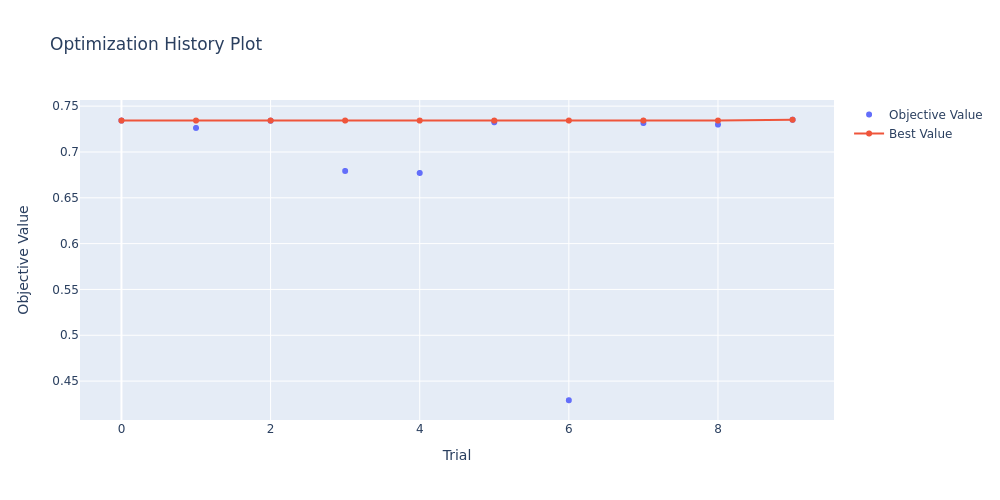

In [10]:
hpo_visualizer.plot_optimization_history(figsize=(1000, 500))

Parallel coordinates:

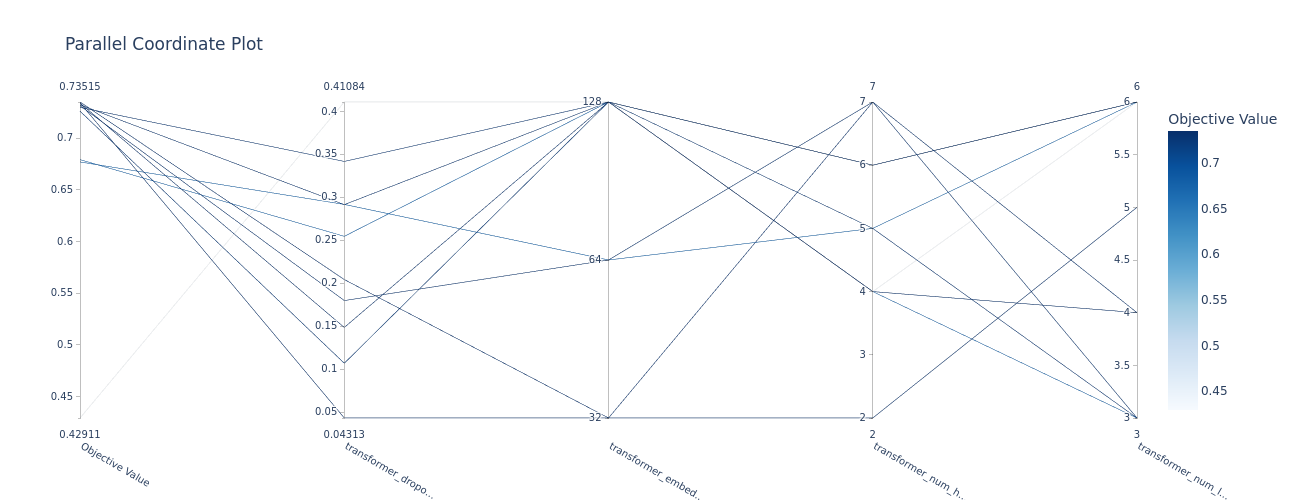

In [19]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=[params for params in study.best_params.keys() if params.startswith('transformer')]
)

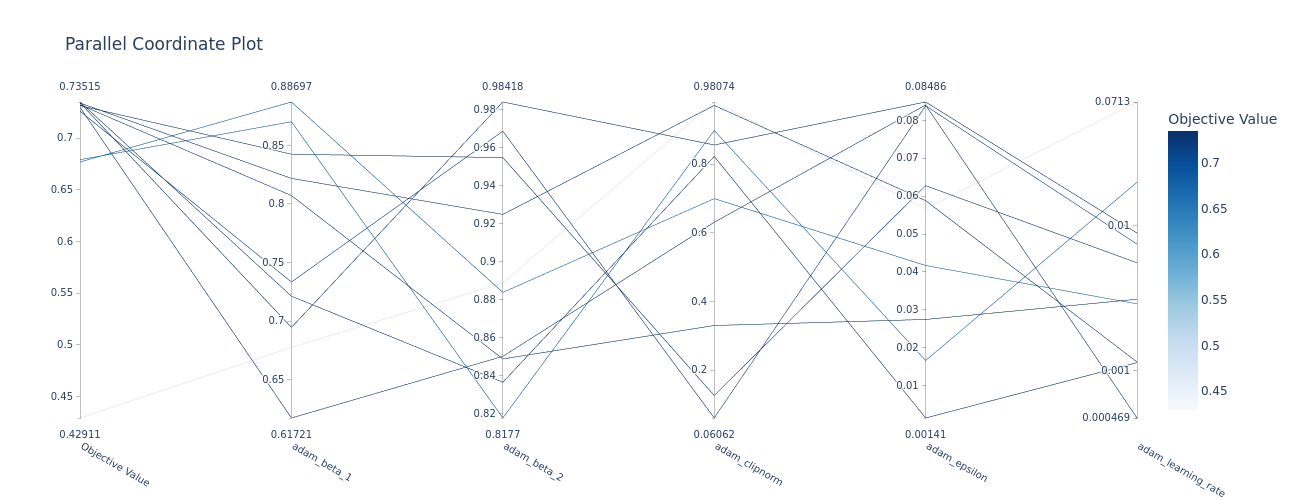

In [20]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=[params for params in study.best_params.keys() if params.startswith('adam')]
)

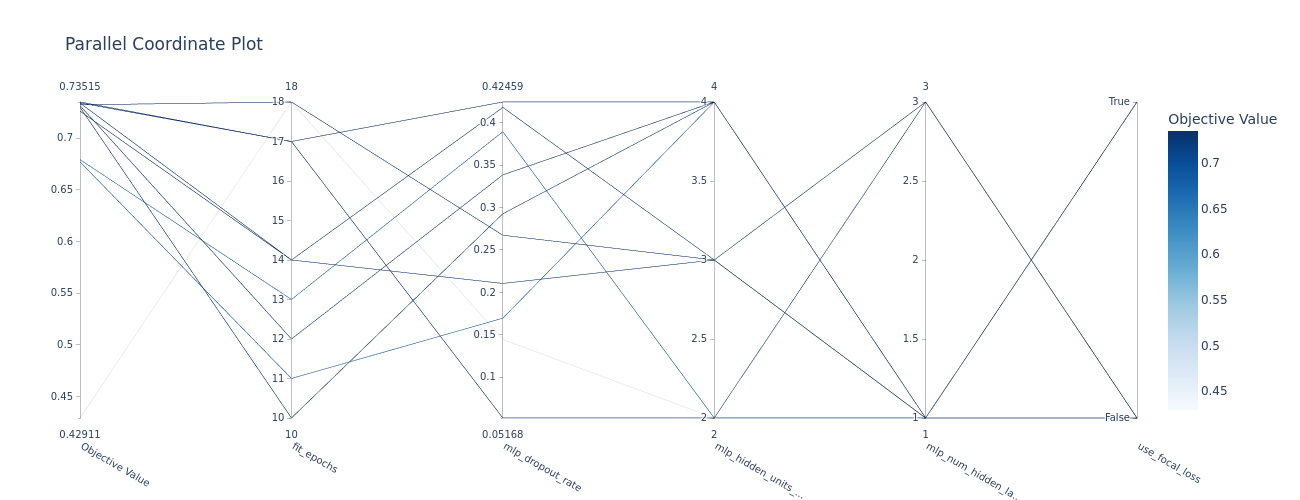

In [21]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=[params for params in study.best_params.keys() if not params.startswith('transformer') and not params.startswith('adam')]
)

Hyperparameter importance:

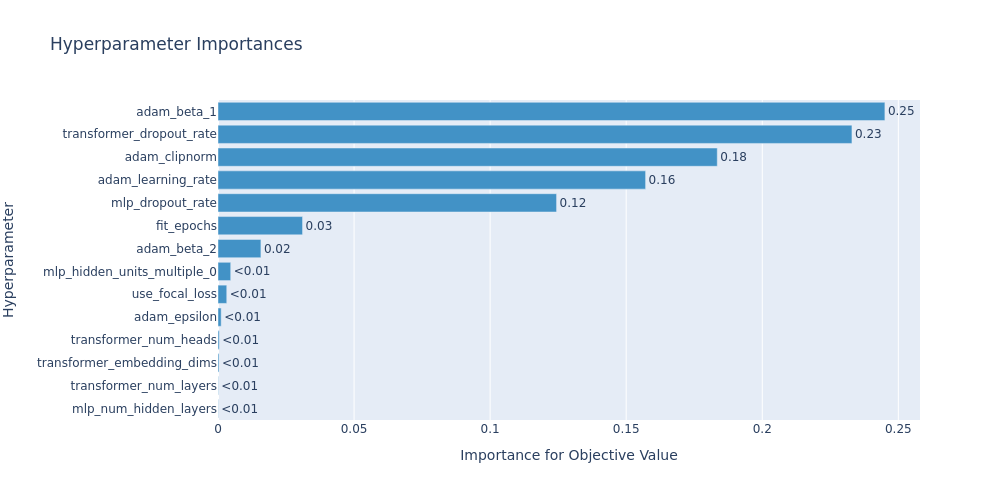

In [24]:
hpo_visualizer.plot_param_importances(figsize=(1000, 500))

### TensorBoard

In [ ]:
tensorboard_log_dir = f's3://{config["s3_bucket"]}/{config["s3_key"]}/tensorboard_logs/{study.best_trial.user_attrs["job_name"]}_{study.best_trial.number}'

!aws s3 cp {tensorboard_log_dir} ./tensorboard_logs --recursive

!tensorboard --logdir ./tensorboard_logs --host localhost --port 6006

In [31]:
!rm -rf ./tensorboard_logs

## Inference on Test Set

In [138]:
test_data = pl.read_csv(f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test/test.csv', new_columns=config['csv_header'])
test_data.shape

(16279, 15)

In [139]:
# Split into weight column, target, and features
weights = test_data['fnlwgt'].to_numpy()

target = test_data.with_columns(
    pl.when(pl.col("income_bracket") == " <=50K").then(0)
      .when(pl.col("income_bracket") == " >50K").then(1)
      .alias('encoded_income_bracket')
).select(['encoded_income_bracket']).to_numpy().flatten()

features = test_data.drop(['fnlwgt', 'income_bracket']).to_numpy()

In [140]:
features

array([[28, ' Local-gov', ' Assoc-acdm', ..., 0, 40, ' United-States'],
       [44, ' Private', ' Some-college', ..., 0, 40, ' United-States'],
       [18, ' ?', ' Some-college', ..., 0, 30, ' United-States'],
       ...,
       [38, ' Private', ' Bachelors', ..., 0, 50, ' United-States'],
       [44, ' Private', ' Bachelors', ..., 0, 40, ' United-States'],
       [35, ' Self-emp-inc', ' Bachelors', ..., 0, 60, ' United-States']],
      dtype=object)

### Deploy Best Model

Build and push serving image to ECR:

In [ ]:
!cd {os.path.dirname(config['container_dir_path'])} && bash ./container/build_and_push.sh serve serving

Construct the image uri:

In [142]:
ecr_images = !aws ecr list-images --repository-name {config['tf_keras']['ecr_repository']}
ecr_images_str = '\n'.join(ecr_images)
ecr_images_str = json.loads(ecr_images_str)
image_tag = ecr_images_str['imageIds'][0]['imageTag']

serving_image_uri = f"{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config['tf_keras']['ecr_repository']}:{image_tag}"
serving_image_uri

'722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:ubuntu20.04-py3.8.10-sagemaker-serving'

In [143]:
best_model_data = os.path.join(tf_estimator.output_path, study.best_trial.user_attrs['job_name'], 'output/model.tar.gz')

best_model = Model(
    image_uri=serving_image_uri,
    model_data=best_model_data,
    role=role,
    name=config['tf_keras']['model_name'],
    code_location=config['code_location'],
    sagemaker_session=sagemaker_session
)

best_model.deploy(
    initial_instance_count=config['tf_keras']['instance_count'],
    instance_type=config['tf_keras']['inference_instance_type'],
    endpoint_name=config['tf_keras']['endpoint_name'] + '-v1'
)

predictor = Predictor(
    endpoint_name=best_model.endpoint_name,
    sagemaker_session=sagemaker_session
)

---!

In [144]:
# Define the batch size (number of samples to be sent for inference at once)
batch_size = 1000

# Generate predictions in batches
num_instances = features.shape[0]
num_batches = (num_instances + batch_size - 1) // batch_size

predicted_labels = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_instances)
    batch = features[start_idx:end_idx]
    
    # Bytes
    prediction_bytes = predictor.predict(str(batch.tolist()))
    # Deserialize byes to list of lists (one list per sample)
    prediction_lists = json.loads(prediction_bytes)
    
    # Append the predicted probabilities matrix to the container list
    predicted_labels.append(prediction_lists)

    # Wait 2 seconds before requesting inference predictions for the next batch
    time.sleep(2)

# Concatenate the predicted matrices from all batches
y_pred_positive = np.concatenate(predicted_labels, axis=0).flatten()

y_pred_positive

100%|██████████| 17/17 [00:38<00:00,  2.26s/it]


array([0.35899872, 0.55043787, 0.00261338, ..., 0.72667813, 0.27330577,
       0.79381531])

Evaluation:

In [145]:
print(classification_report(target, (y_pred_positive > 0.5).astype(np.int8)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12433
           1       0.72      0.58      0.64      3846

    accuracy                           0.85     16279
   macro avg       0.80      0.75      0.77     16279
weighted avg       0.84      0.85      0.84     16279



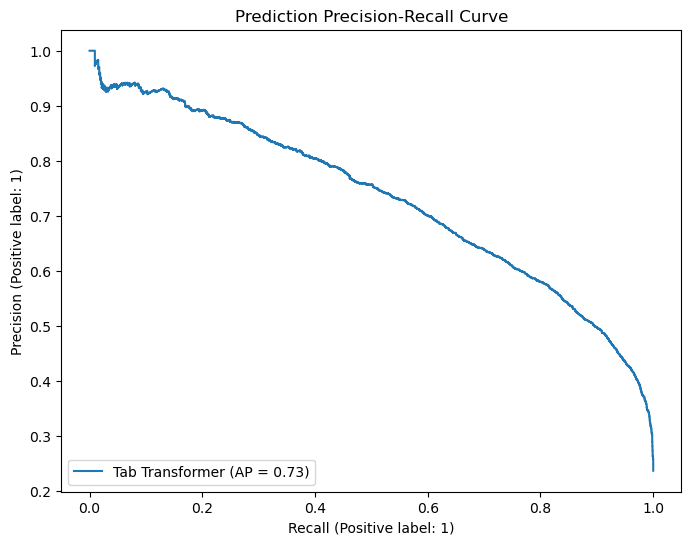

In [146]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(target, y_pred_positive, name='Tab Transformer', ax=ax)
plt.title('Prediction Precision-Recall Curve')
plt.show();

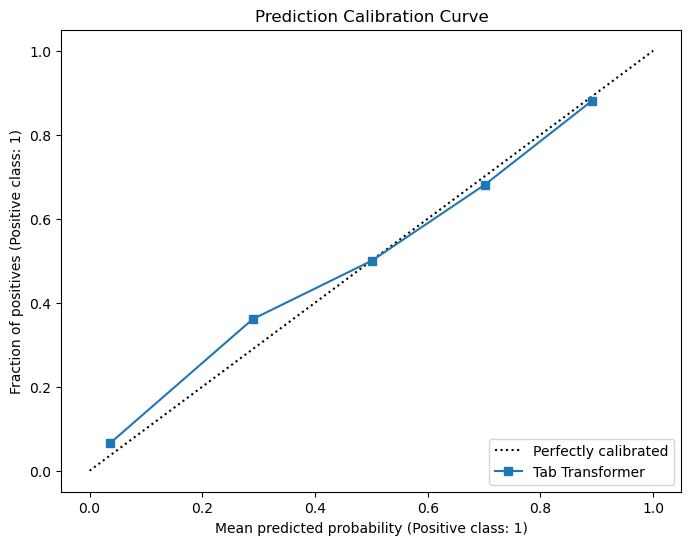

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))
CalibrationDisplay.from_predictions(target, y_pred_positive, name='Tab Transformer', ax=ax)
plt.title('Prediction Calibration Curve')
plt.show();

Because the predictions (logits) are transformed with `tf.nn.sigmoid`, the classifier is well-calibrated. A well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predicted probability value close to, say, 0.8, approximately 80% actually belong to the positive class.

In [154]:
ecr_boto3.batch_delete_image(
    repositoryName=config['tf_keras']['ecr_repository'],
    imageIds=[{'imageTag': image_tag}]
)
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': '1318a4a3-a563-495f-80cb-20f848002021',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1318a4a3-a563-495f-80cb-20f848002021',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 19 Aug 2023 16:02:15 GMT'},
  'RetryAttempts': 0}}

In [155]:
sm_boto3.close()